# Риск и распределение инвестиций в стартапы: классификация

---

# Цель:
- Написать модель машинного обучения для:
    - классификации стартапов (отказ/соглашение финансировать стартап);
    - выявление и интерпретация признаков, влияющих на отказ в финансировании;
    - сохранение модели для дальнейшего использования (расчёт объёма инвестиций на одобренные стсртапы).

In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [156]:
df = pd.read_csv('../data/processed/startup_investment_dataset+rejected_status.csv')

df.head()

,startup_stage,industry,region,requested_amount,pre_money_valuation,team_size,founders_experience_years,annual_revenue,market_size_estimate,investment_amount,is_rejected
0,Pre-Seed,ClimateTech,US,1.381327e+06,7.223187e+06,9,3,0.000000,6.039942e+06,0.000000e+00,1
1,Series B,HealthTech,US,7.784759e+06,3.049307e+07,13,8,96087.461835,6.886030e+07,7.203092e+06,0
2,Pre-Seed,HealthTech,LATAM,1.306439e+06,1.022702e+07,5,3,0.000000,1.896208e+07,0.000000e+00,1
3,Idea,E-commerce,US,8.840830e+05,4.531614e+06,3,2,0.000000,7.717272e+06,0.000000e+00,1
4,Series B,E-commerce,US,1.608484e+07,5.189190e+07,10,7,133652.729965,1.415670e+07,1.672645e+07,0


In [157]:
df['is_rejected'].value_counts()

is_rejected
0    1948
1    1052
Name: count, dtype: int64

In [158]:
df = df.drop(columns=[
    'market_size_estimate', # TAM не используется для принятия решений об инвестировании;
    'investment_amount' # Объём инвестиций равен НУЛЮ, если в финансировании отказано
])

target = 'is_rejected' # Целевая переменная: соглашение - 0, отказ - 1

df.head(3)

,startup_stage,industry,region,requested_amount,pre_money_valuation,team_size,founders_experience_years,annual_revenue,is_rejected
0,Pre-Seed,ClimateTech,US,1.381327e+06,7.223187e+06,9,3,0.000000,1
1,Series B,HealthTech,US,7.784759e+06,3.049307e+07,13,8,96087.461835,0
2,Pre-Seed,HealthTech,LATAM,1.306439e+06,1.022702e+07,5,3,0.000000,1


In [159]:
print(f'Дупликатов: {df.duplicated().sum()}') # Дупликатов не обнаружено

Дупликатов: 0


In [160]:
# Модели для классификации
from sklearn.linear_model import LogisticRegression # Логистическая регрессия
from sklearn.ensemble import RandomForestClassifier # Случайный лес
from sklearn.svm import SVC # Классификатор (опорные векторы)

# Модели градиентного спуска
# from sklearn.ensemble import GradientBoostingClassifier # Классический градиентный бустинг (ОТМЕНЁН - низкая скорость обучения, слабая производительность)
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier

# Преобразование данных
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Пайплайн 
from sklearn.pipeline import Pipeline

# Разбиение данных (train/test)
from sklearn.model_selection import train_test_split, GridSearchCV

# Метрики оценки качества
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score 

# Подготовка данных / препроцессинг

In [161]:
X = df.drop(columns=['is_rejected'])
y = df['is_rejected']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['is_rejected'], test_size=.3, random_state=42)

In [162]:
num_features = X_train.select_dtypes(exclude=['object']).columns.tolist() # Числовые признаки
cat_features = X_train.select_dtypes(include=['object']).columns.tolist() # Категориальные признаки

print(f'Числовые признаки:\n{num_features}')
print('-' * 15)
print(f'Категориальные признаки:\n{cat_features}')

Числовые признаки:
['requested_amount', 'pre_money_valuation', 'team_size', 'founders_experience_years', 'annual_revenue']
---------------
Категориальные признаки:
['startup_stage', 'industry', 'region']


In [163]:
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_features),
    ('encoder', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), cat_features)
])


preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['requested_amount', 'pre_money_valuation',
                                  'team_size', 'founders_experience_years',
                                  'annual_revenue']),
                                ('encoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['startup_stage', 'industry', 'region'])])

# Машинное обучение (модели)

### - Обучены модели машинного обучения, подобраны оптимальные гиперпараметры по метрике `f1-score`:

$$
F1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$ 

$$
\text{precision} = \frac{TP}{TP + FP}, \quad
\text{recall} = \frac{TP}{TP + FN}
$$

- \(TP\) — истинно положительные (правильно предсказанные «отказы»)  
- \(FP\) — ложноположительные (предсказали отказ, но его не было)  
- \(FN\) — ложноотрицательные (не предсказали отказ, а он был)

In [164]:
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

interim_model_path = '../src/models/interim' 

### Logistic Regression

In [165]:
lr_model_path = f'{interim_model_path}/LogisticRegression.joblib'

try:
    lr_model = joblib.load(lr_model_path)
    print('Модель с подобранными гиперпараметрами загружена из файла.')
except FileNotFoundError:
    print('Не найдено модели с подобранными гиперпараметрами; выполняется подбор...')

    lr_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('lr', LogisticRegression(max_iter=1000, n_jobs=-1, solver='saga'))
    ])

    lr_param_grid = {
        'lr__C': [0.01, 0.1, 0.5, 1],
        'lr__penalty': ['l1', 'l2', 'elasticnet'],
        'lr__l1_ratio': [0.2, 0.5, 0.8]
    }

    lr_grid_search = GridSearchCV(
        estimator=lr_pipeline,
        param_grid=lr_param_grid,
        scoring='f1_weighted',
        cv=5,
        n_jobs=-1
    )

    lr_grid_search.fit(X_train, y_train)

    print(f'Лучшие параметры для LogisticRegression: {lr_grid_search.best_params_}')
    print(f'Лучший результат: f1={lr_grid_search.best_score_}')

    lr_model = lr_grid_search.best_estimator_

    os.makedirs(os.path.dirname(lr_model_path), exist_ok=True)
    joblib.dump(lr_model, lr_model_path)

Модель с подобранными гиперпараметрами загружена из файла.


In [166]:
def get_scores(estimator_pipeline, estimator_name):
    y_pred = estimator_pipeline.predict(X_test)
    y_pred_proba = estimator_pipeline.predict_proba(X_test) 

    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'F1: {f1_score(y_test, y_pred)}')
    print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_proba[:, 1])}')
    print(f'Classification report:\n{classification_report(y_test, y_pred)}')
    print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred)}')
    
    joblib.dump(estimator_pipeline, f'../src/models/interim/{estimator_name}.joblib')
    
    return estimator_pipeline

In [167]:
display(lr_model)
lr = get_scores(estimator_pipeline=lr_model, estimator_name='LogisticRegression')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['requested_amount',
                                                   'pre_money_valuation',
                                                   'team_size',
                                                   'founders_experience_years',
                                                   'annual_revenue']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['startup_stage', 'industry',
                                                   'region'])])),
                ('lr',
                 LogisticRegression(C=0.5, l1_ratio=0.2, max_iter=1000,
                                    n_jobs=-1, penalty='elasticnet',
                                    solver='saga'))])

Accuracy: 0.73
F1: 0.574430823117338
ROC-AUC: 0.7563128576382869
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       584
           1       0.64      0.52      0.57       316

    accuracy                           0.73       900
   macro avg       0.70      0.68      0.69       900
weighted avg       0.72      0.73      0.72       900

Confusion matrix:
[[493  91]
 [152 164]]


### Random Forest

In [168]:
rf_model_path = f'{interim_model_path}/RandomForest.joblib'

try:
    rf_model = joblib.load(rf_model_path)
    print('Модель RandomForest успешно загружена из файла.')
except FileNotFoundError:
    print('Не найдено модели RandomForest; выполняется подбор гиперпараметров...')

    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
    ])

    rf_param_grid = {
        'rf__n_estimators': [200, 500],
        'rf__max_depth': [None, 10, 30],
        'rf__min_samples_split': [2, 10],
        'rf__min_samples_leaf': [1, 5],
        'rf__max_features': ['sqrt', 'log2'],
        'rf__criterion': ['gini', 'entropy']
    }

    rf_grid_search = GridSearchCV(
        estimator=rf_pipeline,
        param_grid=rf_param_grid,
        scoring='f1_weighted',
        cv=5,
        n_jobs=-1
    )

    rf_grid_search.fit(X_train, y_train)

    print(f'Лучшие параметры RF: {rf_grid_search.best_params_}')
    print(f'Лучший f1 RF: {rf_grid_search.best_score_}')

    rf_model = rf_grid_search.best_estimator_

    os.makedirs(os.path.dirname(rf_model_path), exist_ok=True)
    joblib.dump(rf_model, rf_model_path)

Модель RandomForest успешно загружена из файла.


In [169]:
display(rf_model)
rf = get_scores(estimator_pipeline=rf_model, estimator_name='RandomForest')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['requested_amount',
                                                   'pre_money_valuation',
                                                   'team_size',
                                                   'founders_experience_years',
                                                   'annual_revenue']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['startup_stage', 'industry',
                                                   'region'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', min_samples_leaf=5,
                                        n_estimators=500, n_jobs=-1,
                                        random_state=42))])

Accuracy: 0.7044444444444444
F1: 0.615606936416185
ROC-AUC: 0.7540478151551934
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       584
           1       0.57      0.67      0.62       316

    accuracy                           0.70       900
   macro avg       0.68      0.70      0.69       900
weighted avg       0.72      0.70      0.71       900

Confusion matrix:
[[421 163]
 [103 213]]


### SVM (Support Vector Classifier)

In [170]:
svc_model_path = f'{interim_model_path}/SVC.joblib'

try:
    svc_model = joblib.load(svc_model_path)
    print('Модель SVC успешно загружена из файла.')
except FileNotFoundError:
    print('Не найдено модели SVC; выполняется подбор гиперпараметров...')

    svc_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('svc', SVC(probability=True, class_weight='balanced', random_state=42))
    ])

    svc_param_grid = [
        {
            'svc__kernel': ['linear'],
            'svc__C': [0.1, 1]
        },
        {
            'svc__kernel': ['rbf'],
            'svc__C': [0.1, 1, 10],
            'svc__gamma': ['scale', 0.01, 0.001]
        }
    ]

    svc_grid_search = GridSearchCV(
        estimator=svc_pipeline,
        param_grid=svc_param_grid,
        scoring='f1_weighted',
        cv=5,
        n_jobs=-1
    )

    svc_grid_search.fit(X_train, y_train)

    print(f'Лучшие параметры SVC: {svc_grid_search.best_params_}')
    print(f'Лучший f1 SVC: {svc_grid_search.best_score_}')

    svc_model = svc_grid_search.best_estimator_

    os.makedirs(os.path.dirname(svc_model_path), exist_ok=True)
    joblib.dump(svc_model, svc_model_path)

Модель SVC успешно загружена из файла.


In [171]:
display(svc_model)
svc = get_scores(estimator_pipeline=svc_model, estimator_name='SVC')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['requested_amount',
                                                   'pre_money_valuation',
                                                   'team_size',
                                                   'founders_experience_years',
                                                   'annual_revenue']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['startup_stage', 'industry',
                                                   'region'])])),
                ('svc',
                 SVC(C=10, class_weight='balanced', gamma=0.01,
                     probability=True, random_state=42))])

Accuracy: 0.6955555555555556
F1: 0.6005830903790087
ROC-AUC: 0.7414708687359112
Classification report:
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       584
           1       0.56      0.65      0.60       316

    accuracy                           0.70       900
   macro avg       0.67      0.69      0.68       900
weighted avg       0.71      0.70      0.70       900

Confusion matrix:
[[420 164]
 [110 206]]


### XGBoost Classifier (экстремальный бустинг)

In [172]:
xgb_model_path = f'{interim_model_path}/XGBClassifier.joblib'

try:
    xgb_model = joblib.load(xgb_model_path)
    print('Модель XGB успешно загружена из файла.')
except FileNotFoundError:
    print('Не найдено модели XGB; выполняется подбор гиперпараметров...')

    xgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('xgb', XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1
        ))
    ])

    xgb_param_grid = {
        'xgb__n_estimators': [200, 400],
        'xgb__learning_rate': [0.01, 0.05, 0.1],
        'xgb__max_depth': [3, 5, 7],
        'xgb__min_child_weight': [1, 5, 10],
        'xgb__subsample': [0.7, 0.9],
        'xgb__colsample_bytree': [0.7, 0.9],
        'xgb__gamma': [0, 1, 5],
        'xgb__reg_alpha': [0, 0.1, 1],
        'xgb__reg_lambda': [1, 5]
    }

    xgb_grid_search = GridSearchCV(
        estimator=xgb_pipeline,
        param_grid=xgb_param_grid,
        scoring='f1_weighted',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    xgb_grid_search.fit(X_train, y_train)

    print(f'Лучшие параметры XGB: {xgb_grid_search.best_params_}')
    print(f'Лучший f1 XGB: {xgb_grid_search.best_score_}')

    xgb_model = xgb_grid_search.best_estimator_

    os.makedirs(os.path.dirname(xgb_model_path), exist_ok=True)
    joblib.dump(xgb_model, xgb_model_path)

Модель XGB успешно загружена из файла.


In [173]:
display(xgb_model)
xgb = get_scores(estimator_pipeline=xgb_model, estimator_name='XGBClassifier')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['requested_amount',
                                                   'pre_money_valuation',
                                                   'team_size',
                                                   'founders_experience_years',
                                                   'annual_revenue']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['startup_stage', 'industry',
                                                   'region'])])),
                ('xgb',
                 XGBClassifier(base_score=N...
                               feature_types=None, feature_weights=None,
                               gamma=5, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=-1,
                               num_parallel_tree=None, ...))])

Accuracy: 0.7322222222222222
F1: 0.5851979345955249
ROC-AUC: 0.760593679556095
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       584
           1       0.64      0.54      0.59       316

    accuracy                           0.73       900
   macro avg       0.71      0.69      0.69       900
weighted avg       0.72      0.73      0.73       900

Confusion matrix:
[[489  95]
 [146 170]]


### LightGBM Classifier

In [174]:
lgbm_model_path = f'{interim_model_path}/LGBMClassifier.joblib'

try:
    lgbm_model = joblib.load(lgbm_model_path)
    print('Модель LightGBM успешно загружена из файла.')
except FileNotFoundError:
    print('Не найдено модели LightGBM; выполняется подбор гиперпараметров...')

    lgbm_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('lgbm', LGBMClassifier(
            objective='binary',
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ))
    ])

    lgbm_param_grid = {
        'lgbm__n_estimators': [200, 500],
        'lgbm__learning_rate': [0.05, 0.1],
        'lgbm__max_depth': [-1, 5, 10],
        'lgbm__num_leaves': [31, 63, 127],
        'lgbm__min_child_samples': [20, 50],
        'lgbm__subsample': [0.7, 0.9],
        'lgbm__colsample_bytree': [0.7, 0.9]
    }

    lgbm_grid_search = GridSearchCV(
        estimator=lgbm_pipeline,
        param_grid=lgbm_param_grid,
        scoring='f1_weighted',
        cv=5,
        n_jobs=-1
    )

    lgbm_grid_search.fit(X_train, y_train)

    print(f'Лучшие параметры LightGBM: {lgbm_grid_search.best_params_}')
    print(f'Лучший f1 LightGBM: {lgbm_grid_search.best_score_}')

    lgbm_model = lgbm_grid_search.best_estimator_

    os.makedirs(os.path.dirname(lgbm_model_path), exist_ok=True)
    joblib.dump(lgbm_model, lgbm_model_path)

Модель LightGBM успешно загружена из файла.


In [175]:
display(lgbm_model)
lgbm = get_scores(estimator_pipeline=lgbm_model, estimator_name='LGBMClassifier')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['requested_amount',
                                                   'pre_money_valuation',
                                                   'team_size',
                                                   'founders_experience_years',
                                                   'annual_revenue']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['startup_stage', 'industry',
                                                   'region'])])),
                ('lgbm',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.9,
                                learning_rate=0.05, max_depth=5,
                                min_child_samples=50, n_estimators=200,
                                n_jobs=-1, objective='binary', random_state=42,
                                subsample=0.7))])

Accuracy: 0.6755555555555556
F1: 0.6085790884718498
ROC-AUC: 0.7423189049765909
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.65      0.72       584
           1       0.53      0.72      0.61       316

    accuracy                           0.68       900
   macro avg       0.67      0.69      0.67       900
weighted avg       0.71      0.68      0.68       900

Confusion matrix:
[[381 203]
 [ 89 227]]


# Результаты

### Самая оптимальная модель - `LightGBM` (меньше всего FN (пропусков "невалидных" стартапов)).

- Recall(1): 0.72

- F1(1): 0.61

- ROC-AUC: 0.742

- FN = 89 (__⭐ лучший__)

---

**Интерпретация выбора**: выбор был сделан в пользу минимализации пропуска ненадёжных стартапов - лучше пропустить надёжные, чем профинансировать те, которые потенциально закрываются.

---

# Подбор лучшего вероятностного порога

In [176]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# вероятности отказа (класс 1)
y_proba = lgbm_model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.1, 0.9, 81)

results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    
    results.append({
        'threshold': t,
        'f1': f1_score(y_test, y_pred_t),
        'precision': precision_score(y_test, y_pred_t),
        'recall': recall_score(y_test, y_pred_t)
    })

results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['f1'].idxmax()]

display(best_row)
display(results_df.head())

threshold    0.510000
f1           0.611413
precision    0.535714
recall       0.712025
Name: 41, dtype: float64

,threshold,f1,precision,recall
0,0.10,0.533448,0.365882,0.984177
1,0.11,0.537391,0.370504,0.977848
2,0.12,0.543689,0.376989,0.974684
3,0.13,0.547406,0.381546,0.968354
4,0.14,0.551537,0.386076,0.965190


# **LightGBM**

- Для модели LightGBM оптимальный порог вероятности для классификации составляет **0.51**. Класс 1 (отказ) присваивается стартапом, для которых вероятность отказа превышает этот порог.

---

# Модели и результаты классификации
## Класс 1 - отказ

| Модель             | Accuracy | F1(1) | ROC-AUC | Recall(1) | FP / FN | Примечание |
| ------------------ | -------- | ------------- | ------- | --------- | ------- | ----- |
| LogisticRegression | <span style='color:green'>0.73</span>     | <span style='color:red'>0.57</span>          | 0.756   | 0.52      | <span style='color:red'>FN=152</span>  | Интерпретируемый baseline с высокой accuracy, но слабым recall по отказам |
| RandomForest       | 0.70     | <span style='color:green'>0.62</span>          | 0.754   | 0.67      | FN=103  | Самый оптимальный баланс устойчивости и поиска отказов |
| SVM                | 0.70     | 0.60          | <span style='color:red'>0.741<span>   | 0.65      | FN=110  | Сложна в тюнинге и интерпретации для данной задачи |
| XGBoost            | <span style='color:green'>0.73</span>     | 0.59          | <span style='color:green'>0.761</span>   | <span style='color:red'>0.54</span>      | FN=146  | Слабый recall для класса отказа - большое число FN |
| LightGBM           | <span style='color:red'>0.68</span>     | 0.61          | 0.742   | <span style='color:green'>0.72</span>      | <span style='color:green'>FN=89</span>   | <span style='color:green'>Минимальное число FN при <span style='color:red'>высокой чувствительности</span> к отказам/FN</span> |


# Влияние признаков на отказ (LightGBM)

In [192]:
model = lgbm.named_steps['lgbm']
preprocessor = lgbm.named_steps['preprocessor']

feature_importances = model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

print('> Модель:')
display(model)
print('> Препроцессор:')
display(preprocessor)
print('> Признаки:')
display(feature_names)
print('> Значимости признаков:')
display(feature_importances)

> Модель:


LGBMClassifier(class_weight='balanced', colsample_bytree=0.9,
               learning_rate=0.05, max_depth=5, min_child_samples=50,
               n_estimators=200, n_jobs=-1, objective='binary', random_state=42,
               subsample=0.7)

> Препроцессор:


ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['requested_amount', 'pre_money_valuation',
                                  'team_size', 'founders_experience_years',
                                  'annual_revenue']),
                                ('encoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['startup_stage', 'industry', 'region'])])

> Признаки:


array(['scaler__requested_amount', 'scaler__pre_money_valuation',
       'scaler__team_size', 'scaler__founders_experience_years',
       'scaler__annual_revenue', 'encoder__startup_stage_Pre-Seed',
       'encoder__startup_stage_Seed', 'encoder__startup_stage_Series A',
       'encoder__startup_stage_Series B', 'encoder__industry_ClimateTech',
       'encoder__industry_E-commerce', 'encoder__industry_EdTech',
       'encoder__industry_FinTech', 'encoder__industry_HealthTech',
       'encoder__region_Europe', 'encoder__region_LATAM',
       'encoder__region_US'], dtype=object)

> Значимости признаков:


array([683, 558, 229, 226, 412,  48,  26,  31,   2,  10,  17,  11,  43,
        19,  41,   8,  77], dtype=int32)

,feature_name,importance
0,scaler__requested_amount,683
1,scaler__pre_money_valuation,558
4,scaler__annual_revenue,412
2,scaler__team_size,229
3,scaler__founders_experience_years,226
16,encoder__region_US,77
5,encoder__startup_stage_Pre-Seed,48
12,encoder__industry_FinTech,43
14,encoder__region_Europe,41
7,encoder__startup_stage_Series A,31


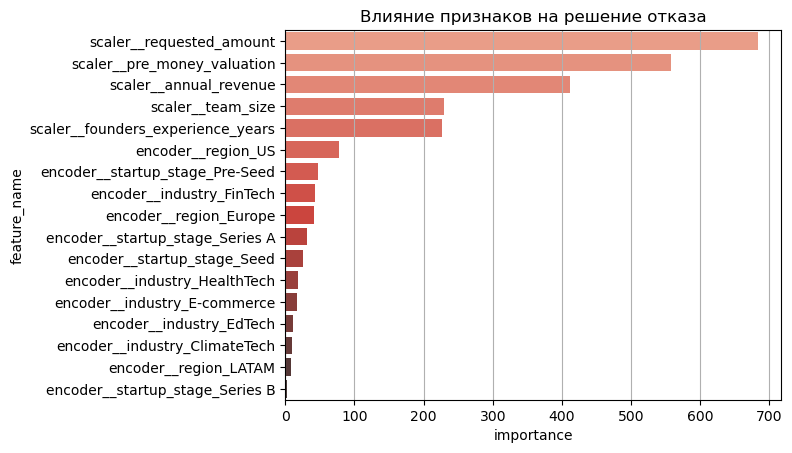

In [206]:
feature_importances_df = pd.DataFrame({
    'feature_name': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

display(feature_importances_df)

sns.barplot(data=feature_importances_df, x='importance', y='feature_name', palette='Reds_d')
plt.title('Влияние признаков на решение отказа')
plt.grid(axis='x')
plt.show()

## Интерпретация влияния признаков на решение о финансировании стартапа

Анализ важности признаков модели LightGBM показал следующие ключевые закономерности:

1. **Количественные показатели стартапа доминируют**:
   - `requested_amount` (объём запрашиваемых инвестиций) — самый сильный фактор: большие суммы повышают вероятность отказа.
   - `pre_money_valuation` (оценка стартапа до инвестиций) — слишком высокая оценка увеличивает риск отказа.
   - `annual_revenue` (годовой доход) — более высокий доход снижает вероятность отказа.
   - `team_size` и `founders_experience_years` — опытная и крупная команда повышает шансы на финансирование.

2. **Географические и отраслевые особенности**:
   - Стартапы из США (`region_US`) получают финансирование чаще, в то время как Европа и LATAM показывают более высокий риск отказа.
   - Отрасль также влияет: FinTech имеет наибольший вес среди категориальных признаков, другие — HealthTech, E-commerce, EdTech, ClimateTech — менее значимы.

3. **Стадия стартапа**:
   - Стартапы на ранних стадиях (`Pre-Seed`) имеют более высокий риск отказа.
   - Поздние стадии (Seed, Series A, B) снижают вероятность отказа.

**Вывод:**  
Модель показывает, что решения инвесторов в первую очередь зависят от **финансовых и командных характеристик** стартапа, а также учитывают **регион, отрасль и стадию развития**. Для минимизации риска отказа стартапы должны запрашивать разумные суммы, демонстрировать доход и компетентность команды, а также учитывать региональные и отраслевые особенности.

In [208]:
try:
    joblib.dump(model, '../src/models/classifier_lgbm.joblib')
    print('Финальная модель LightGBM сохранена в src/models/classifier_lgbm.joblib.')
except Exception as e:
    print(f'Не удалось сохранить модель:\n{e}')

Финальная модель LightGBM сохранена в src/models/classifier_lgbm.joblib.
